# Hacking The IT Industry: A Characterization of the Philippines' IT Job Market

## Executive Summary

The IT field is a very broad and fast paced industry, with new technologies popping up almost every year. This makes it difficult for fresh graduates and career shifters to develop their skill set, let alone land their dream jobs. Furthermore, a lot of companies have their own unique set of job titles which do not reflect the skill sets that they require for the job. This makes it all the more confusing for both applicants and recruiters alike.

This notebook aims to address this problem through the use of topic modelling (LDA). The idea is that job posts can be grouped together according to their required skills and technologies. This allows us to reconcile the job titles as well as highlight skills that go together.

Results show that LDA was capable of coming up with meaningful groupings (sub-industries) and we are able to identify **8 general clusters**. These results can further be used for downstream tasks such as item set mining (to find skill and tech pairings per sub-industry) and semi-supervised learning for classification and sequence to sequence modeling.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Executive-Summary" data-toc-modified-id="Executive-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Executive Summary</a></span></li><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Functions</a></span></li><li><span><a href="#The-Data" data-toc-modified-id="The-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Filter-by-Industry-and-Drop-Duplicates" data-toc-modified-id="Filter-by-Industry-and-Drop-Duplicates-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Filter by Industry and Drop Duplicates</a></span></li><li><span><a href="#Lower-Casing" data-toc-modified-id="Lower-Casing-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Lower Casing</a></span></li><li><span><a href="#Tokenization" data-toc-modified-id="Tokenization-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Tokenization</a></span></li><li><span><a href="#Lemmatization" data-toc-modified-id="Lemmatization-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Lemmatization</a></span></li><li><span><a href="#Distribution-of-Word-Token-Counts" data-toc-modified-id="Distribution-of-Word-Token-Counts-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Distribution of Word Token Counts</a></span></li><li><span><a href="#Low-Frequency-Words" data-toc-modified-id="Low-Frequency-Words-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Low Frequency Words</a></span></li><li><span><a href="#Standard-Stop-Words-(Spacy)" data-toc-modified-id="Standard-Stop-Words-(Spacy)-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Standard Stop Words (Spacy)</a></span></li><li><span><a href="#Custom-Stop-Words" data-toc-modified-id="Custom-Stop-Words-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>Custom Stop Words</a></span></li><li><span><a href="#Combine-all-Stop-Words" data-toc-modified-id="Combine-all-Stop-Words-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>Combine all Stop Words</a></span></li><li><span><a href="#Remove-Stop-Words" data-toc-modified-id="Remove-Stop-Words-5.10"><span class="toc-item-num">5.10&nbsp;&nbsp;</span>Remove Stop Words</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#LDA-Topic-Modelling" data-toc-modified-id="LDA-Topic-Modelling-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>LDA Topic Modelling</a></span></li><li><span><a href="#Model-Across-Different-Hyperparameters" data-toc-modified-id="Model-Across-Different-Hyperparameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Model Across Different Hyperparameters</a></span></li><li><span><a href="#Visualizing-Topic-Clusters" data-toc-modified-id="Visualizing-Topic-Clusters-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Visualizing Topic Clusters</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Recommendations</a></span></li></ul></div>

## Import Packages

In [96]:
import sqlite3
import re
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim
pd.options.mode.chained_assignment = None

## Define Functions

In [2]:
def plt_token_count_dist(df, col, token_pattern=r'\w+', scale='log'):
    '''This function displays the frequency distribution of a a range of
    documents that are stored under a particular column in a dataframe.
    
    Parameters:
    -----------
        df: dataframe
            Dataframe containing the data.
        col: string
            Column label to perform the operation on.
    '''
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)
    ax.hist(df[col].apply(lambda x: 
                          len(re.findall(token_pattern, x))), bins=30);
    ax.set_title('Frequency Distribution of Token Counts per Document')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Token Count')
    ax.set_yscale(scale)
    plt.show()
    
def tokenize(pattern, text):
    '''Performs the tokenization on the input text using the specified 
    regex pattern.
    '''
    
    # Correct the spacing of some of the scraped text.
    text = re.sub(r'(?<=\w)[.](?=\w)',' ', text)
    return ' '.join(re.findall(pattern, text))

def lemmatizer(sp, text):
    doc = sp(text)
    
    holder = []
    for token in doc:
        holder.append(token.lemma_)
    
    return ' '.join(holder)

def remove_stop(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

## The Data

The dataset was obtained by scraping one of the popular job posting sites in the Philippines. We got permission from the owner to work on the dataset for this analysis.

In [3]:
conn_js = sqlite3.connect('jobstreet.db')
c_js = conn_js.cursor()
c_js.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c_js.fetchall())

[('jobstreet',)]


In [4]:
df_js = pd.read_sql("SELECT * FROM jobstreet", conn_js)
display(df_js.head())
print(df_js.shape)

,id,title,company_id,company,company_industry,description,work_hours,region,location,experience,list_date,expiration_date,industry
0,7479663,Generator Electrical Technician,492613.0,"QUINTRIX INTERNATIONAL MANPOWER CENTER, INC.",Human Resources Management/Consulting,Candidate must possess at least a Vocational D...,None,Saudi Arabia - Riyadh,"4226 Laredo Street, Palanan, Makati",Min 5 years (Supervisor/5 Yrs & Up Experienced...,1509984000,1512576000,None
1,7479643,Generator Mechanical Technician,492613.0,"QUINTRIX INTERNATIONAL MANPOWER CENTER, INC.",Human Resources Management/Consulting,Candidate must possess at least a Bachelor's/C...,None,Saudi Arabia - Riyadh,"4226 Laredo Street, Palanan, Makati",Min 5 years (Supervisor/5 Yrs & Up Experienced...,1509984000,1512576000,None
2,7479634,Vehicle Mechanic,492613.0,"QUINTRIX INTERNATIONAL MANPOWER CENTER, INC.",Human Resources Management/Consulting,Candidate must possess at least a Vocational D...,None,Saudi Arabia - Riyadh,"4226 Laredo Street, Palanan, Makati",Min 5 years (Supervisor/5 Yrs & Up Experienced...,1509984000,1512576000,None
3,7479629,Vehicle Electrician,492613.0,"QUINTRIX INTERNATIONAL MANPOWER CENTER, INC.",Human Resources Management/Consulting,Candidate must possess at least a Vocational D...,None,Saudi Arabia - Riyadh,"4226 Laredo Street, Palanan, Makati",Min 5 years (Supervisor/5 Yrs & Up Experienced...,1509984000,1512576000,None
4,7479624,Portfolio Reconciliation Analyst,NaN,Manulife Business Processing Services,Call Center/IT-Enabled Services/BPO,Are you looking for unlimited opportunities to...,"Regular hours, Mondays - Fridays",Philippines - Central Visayas - Cebu (Cebu City),"The Mactan Newtown, Lapu-Lapu City, Central Vi...",Less than 1 year experience,1509984000,1512576000,None


(433009, 13)


## Data Cleaning

### Filter by Industry and Drop Duplicates

A quick look at the different industries shows that there are non-IT related job posts which are out of the scope of this notebook. As such, the data frame will be filtered by checking for the "IT" substring under the `industry` column.

In addition, some job posts were repeatedly scraped and this is partly due to how JobStreet implements its advertisements. We drop duplicate job descriptions as we are only interested in unique instances.

In [5]:
industries = df_js['industry'].unique()
print(industries[:25])

[None 'Finance - General/Cost Accounting' 'Sales - Retail/General'
 'Arts/Creative/Graphics Design' 'Banking/Financial Services'
 'Healthcare - Nurse/Medical Support & Assistant'
 'Food/Beverage/Restaurant Service'
 'General Work (Housekeeper, Driver, Dispatch, Messenger, etc)'
 'Personal Care/Beauty/Fitness Service'
 'Manufacturing/Production Operations' 'Engineering - Others'
 'Customer Service'
 'Property/Real Estate, Clerical/Administrative Support'
 'Quality Control/Assurance' 'IT/Computer - Network/System/Database Admin'
 'Engineering - Mechanical/Automotive' 'Human Resources'
 'Engineering - Electronics/Communication' 'IT/Computer - Software'
 'Aviation/Aircraft Maintenance' 'IT/Computer - Hardware'
 'Corporate Strategy/Top Management' 'Marketing/Business Development'
 'Healthcare - Nurse/Medical Support & Assistant, Education'
 'Engineering - Civil/Construction/Structural']


In [6]:
# Drop null values to avoid error
df_js = df_js.dropna(subset=['industry'])

# Get only IT job posts
df_js_IT = df_js[df_js['industry'].str.contains("IT")]

# Drop duplicates
df_js_IT = df_js_IT.drop_duplicates(subset=['description'])
df_js_IT.shape

(32534, 13)

### Lower Casing

The job descriptions (under the column `description`) will be converted to lowercase prior to analysis. This serves to reduce the noise due to case sensitivity.

In [7]:
df_js_IT['description'] = df_js_IT['description'].str.lower()

### Tokenization

For this particular use case, tokens are defined as a sequence of characters that are separated by a white space. These sequences must contain an alphabet character and may contain special characters such as '#', '.' and '++'. In addition, these sequences may also have numerical digits. This major caveat is due to the fact that there are many IT technologies that have special / numerical characters (e.g. C++, .NET, C#, CSS2). The code below performs the tokenization for each document in the corpus.

In [8]:
df_js_IT['tokenized'] = df_js_IT['description'].apply(lambda x:
                                                      tokenize(r"\w*[.]{0,1}[a-z]+[']{0,1}\w*[+#]{0,2}", x))

### Lemmatization

Lemmatization was done in order to reconcile words that stemmed from the same root word but with different inflections. This serves to further reduce the number of unique tokens to parse. A custom lemmatizer can also be applied which could further improve the results by translating abbreviated words. For this analysis, however, the proponents will forego this for now.

In [10]:
sp = spacy.load("en")
df_js_IT['lemmatized'] = df_js_IT['tokenized'].apply(lambda x:
                                                     lemmatizer(sp, x))

Dropping duplicates again using the pre-processed text further reduces the size of the data. It seems that there were some job posts that only differed due to noisy characters. 

In [11]:
# Drop duplicates
df_js_IT = df_js_IT.drop_duplicates(subset=['lemmatized'])
df_js_IT.shape

(29061, 15)

### Distribution of Word Token Counts

In [12]:
all_jds = ' '.join(df_js_IT.lemmatized.values)
token_count = Counter(all_jds.split())
df_tokens = pd.DataFrame(token_count.items(), columns=['word','count'])
df_tokens.shape

(49922, 2)

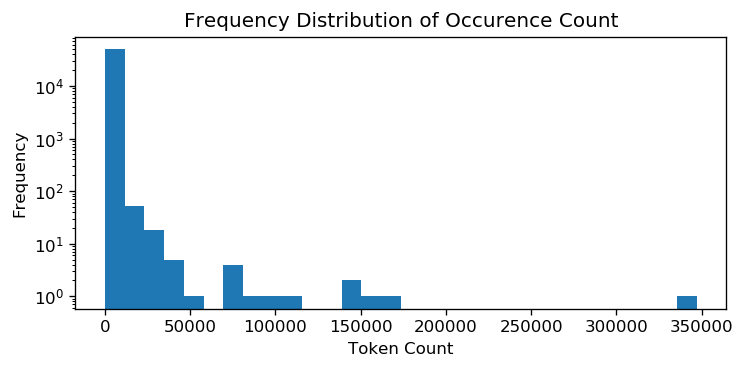

In [151]:
fig, ax = plt.subplots(figsize=(7,3), dpi=120)
ax.hist(df_tokens['count'].values, bins=30);
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency Distribution of Occurence Count');

The plot above shows that the words follow a power law distribution wherein it can be seen that majority of the words have an occurrence count that is less than 50k. All words with frequencies that are less than or equal to the 85th percentile will be dropped from the corpus as they do not occur frequently enough to be considered as "keywords". It is also possible that these words were just misspellings to begin with, but this won't be pursued any further as it will take too big of an effort to correct a few of these mistakes.

In [14]:
df_tokens['count'].quantile(0.85)

15.0

Meanwhile, many of the frequent words are just stop words that do not give any information and are only used for grammatical reasons (e.g. the, and, is). Furthermore, **manual visual inspection of some of the job descriptions revealed that many of the job description have added information beyond that of the actual job.** This is because jobstreet does not enforce a standard format and as such, hiring personnel may sometimes add information beyond that of the job description (e.g. about the company or information on benefits). As such, additional stop words were added as needed to further reduce the noise.

### Low Frequency Words

Words that are too rare to be characteristic of the IT industry.

In [51]:
lf_stop_words = set(df_tokens[df_tokens['count']<=15]['word'].values)

### Standard Stop Words (Spacy)

Words that are common but don't add any useful information.

In [84]:
sp = spacy.load("en")
all_stopwords = sp.Defaults.stop_words

### Custom Stop Words

Words that are not related to the job function / skills / requirements. These may include company names, shift details and employee benefits.

In [201]:
with open('stop_words.txt','r') as f:
    hf_stop_words = list(map(lambda x: x.strip(),f.readlines()))

### Combine all Stop Words

In [202]:
stop_words = lf_stop_words.union(hf_stop_words).union(all_stopwords)

### Remove Stop Words

In [203]:
df_js_IT['drop_stop'] = df_js_IT['lemmatized'].apply(lambda x:
                                                     remove_stop(x,
                                                                 stop_words))

df_js_IT = df_js_IT.drop_duplicates(subset=['drop_stop'])
df_js_IT.shape

(27961, 16)

It seems some of numbers were extracted out during the lemmatization phase. This will be removed to avoid adding noise in the modeling phase.

In [204]:
df_js_IT['drop_stop'] = df_js_IT['drop_stop'].apply(lambda x: re.sub(r'\d+','',x))

## Modeling

In the context of job characterization, we define a keyword as anything that has to do with skills and functions. Since the data is unlabeled and free of form. Some posts contain long paragraphs with grammatically correct sentences, where as others are mainly bulleted. Because of this we have decided to utilize LDA, an unsupervised machine learning algorithm that tries to create document groupings based on the presence of certain keywords. Other methodologies that were considered will be discussed in the appendix / recommendations portion of this notebook.


### LDA Topic Modelling

To model the corpus it must first be converted to a bag of words form. This is done creating a dictionary of word - index and then simply counting the occurrences of each word. We take it a step further by also vectorizing bigrams and trigrams since there are technologies and skills that consists of 2 or more words (e.g. Visual Basic).

In [205]:
docs = df_js_IT['drop_stop'].apply(lambda x: x.split()).values

# Add bigrams and trigrams present in at least 20 documents.
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

Results can further be improved through the use of TFIDF vectorization where each vector is weighted based on their frequency of occurence in other texts.

In [206]:
# Perform TFIDF
tfidf_model = TfidfModel(corpus)

tfidf_docs = [tfidf_model[doc] for doc in corpus]

### Model Across Different Hyperparameters

The LDA model has several important hyperparameters, the most important one being the number of topics. We can determine the optimal number of topics by creating multiple LDA models using different number of topics and then selecting the model with the best coherence score. In the interest of time the coherence scoring metric "umass" was chosen as it was the fastest to compute. Note that for umass, the coherence scores are in the negative domain and caps out at zero. The best model therefore is the model that is closest to zero. A random seed of `42` was specified to ensure that the results are repeatable.

In [207]:
cm_holder = []
for k in range(2,15):
    model = LdaMulticore(corpus=tfidf_docs, 
                         workers=3,
                         id2word=dictionary, 
                         iterations=50, eval_every=None,
                         num_topics=k,
                         random_state=42,
                         passes=5)
    cm = CoherenceModel(model=model, corpus=tfidf_docs,
                        dictionary=dictionary, coherence='u_mass', topn=25)
    cm_holder.append(cm.get_coherence())
    print(k,cm.get_coherence())

2 -1.2201840379888051
3 -1.5693224956271752
4 -1.749294472846925
5 -1.5730042530692279
6 -1.9938124022774568
7 -2.1140774549667984
8 -2.6503140434670343
9 -1.878647638758493
10 -1.8436662501106635
11 -2.743865651484118
12 -1.9513690992336545
13 -2.6407652725320885
14 -3.0561000261913533


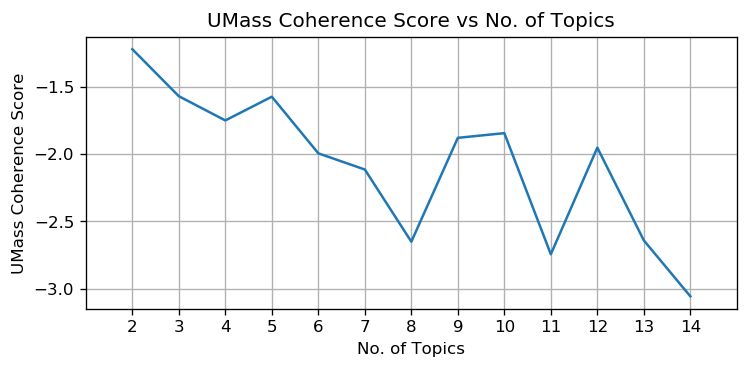

In [221]:
fig, ax = plt.subplots(figsize=(7,3), dpi=120)
ax.plot(range(2,15), cm_holder)
ax.set_xticks(range(2,15))
ax.set_xlim(1,15)
ax.set_xlabel('No. of Topics')
ax.set_ylabel('UMass Coherence Score')
ax.set_title('UMass Coherence Score vs No. of Topics')
ax.grid()

The plot above shows that the LDA model performs best when the number of topics is set to 2. There is high coherence when using a smaller number of topic clusters and this is a result of the model overgeneralizing (i.e. ignoring minority clusters). As such, arguments can be made for the creation of more topic clusters so long as the coherence score is relatively high. Interestingly, there is a spike in coherence when trying to generalize using 10 topics.

### Visualizing Topic Clusters

After determining the best model to use we can visualize the topics via the `pyLDAvis` package.

In [225]:
model = LdaMulticore(corpus=tfidf_docs, 
                     workers=3,
                     id2word=dictionary, 
                     iterations=50, eval_every=None,
                     num_topics=10,
                     random_state=42,
                     passes=5)

In [226]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, tfidf_docs, dictionary, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.040263  0.094101       1        1  20.765827
8     -0.067382  0.003738       2        1  17.394457
7     -0.105094 -0.153366       3        1  13.249932
0      0.061473  0.165341       4        1  12.269434
1     -0.038215 -0.153311       5        1   9.301240
6     -0.142212  0.208250       6        1   7.410569
5      0.126122  0.051877       7        1   6.941181
9     -0.253314 -0.060357       8        1   4.725551
2      0.144039 -0.218206       9        1   4.530546
3      0.314847  0.061934      10        1   3.411265, topic_info=                            Term        Freq       Total Category  logprob  \
56                          sale  554.000000  554.000000  Default  30.0000   
82    computer_telecommunication  460.000000  460.000000  Default  29.0000   
215                          sap  384.000000  384.000000  Default  28.0000   
66             telecommunication  457.000000  457.000000  Default  27.0000   
7                       computer  613.000000  613.000000  Default  26.0000   
...                          ...         ...         ...      ...      ...   
1697                          js   19.313263  190.167664  Topic10  -5.8510   
1991                         ave   17.271481   60.273251  Topic10  -5.9628   
1326                     package   18.192465  139.362106  Topic10  -5.9108   
1583                  prioritize   17.689934   94.372360  Topic10  -5.9388   
13                        course   17.539351  268.113892  Topic10  -5.9474   

      loglift  
56    30.0000  
82    29.0000  
215   28.0000  
66    27.0000  
7     26.0000  
...       ...  
1697   1.0910  
1991   2.1283  
1326   1.3420  
1583   1.7038  
13     0.6511  

[796 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
472       1  0.004010                    #
472       2  0.072174                    #
472       3  0.084204                    #
472       5  0.789910                    #
472       6  0.004010                    #
...     ...       ...                  ...
4533      5  0.939766         zigzagcareer
4534      5  0.939767  zigzagcareer_follow
4535      5  0.934616          zigzagmedia
4536      5  0.939767     zigzagmedia_page
4537      5  0.939767        zigzagmediaph

[2947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 8, 1, 2, 7, 6, 10, 3, 4])

## Results

A good topic model should ideally have high coherence scores and topics clusters that are far apart from each other; note however, that topics close to each other also indicates that they're related. Topic clusters must also have consistent and meaningful top words that reflect what the topic is all about. After reviewing the results for models that used 5, 9 10, 12 topics, we found that a topic model of 10 yielded the best result. The picture below shows a sample result for topic cluster number 3 (Web Development).

<img src='https://github.com/silvski/Characterizing-the-Philippines-IT-Industry/blob/master/results/3.JPG?raw=true'>

* Topic Cluster 1: Project Management
    * Has keywords: project, management, stakeholder, business, budget, ERP and interestingly even SAP.


* Topic Cluster 2: Quality Assurance w/ Salesforce and Data Analytics
    * Has keywords: QA, Test, Salesforce, Automation, Agile, Scrum, BI (Business Intelligence), ETL, Data
    * Salesforce cloud services is for customer relationship management, this includes data analytics and marketing automation.


* Topic Cluster 3: Web Development
    * Has keywords: php, javascript, web, css, html, angularjs, developer


* Topic Cluster 4: Network Engineering and Security
    * Has keywords: security, network, cisco, firewall, incident, ip, lan, infrastructure


* Topic Cluster 5: Software Developer
    * Has keywords: net, vb, asp, c, c#, c++, sql


* Topic Cluster 6: Sales IT / Engineer
    * Has keywords: sales, sell, negotiation, marketing, product, engineer


* Topic Cluster 7: Network / Database Administrator
    * Has keywords: network, hardware, repair, troubleshoot, database, server, admin


* Topic Cluster 8: NOISY CLUSTER: SAP + Mobile App Dev + Vocational
    * Has keywords: SAP, ABAP, Android, Swift, MM, Vocational, Short Courses


* Topic Cluster 9: Bilingual Telco
    * Has keywords: Japanese, Mandarin, Korean, telecommunications


* Topic Cluster 10: NOISY CLUSTER: BPO
    * Has keywords: BPO, Agent, ACCT, tsr, csr

The results are not perfect, since it's clear that certain clusters could further be subdivided, whereas other clusters are downright ambiguous (cluster 10). However, what's important here was that we are able to create and describe the general groupings from thousands of text documents which can help in down stream analysis such as item set mining and semi-supervised / self-supervised learning.

## Conclusion

We have shown that LDA is capable of coming up with meaningful sub-groupings of job posts by grouping them according to their respective key words. This can help applicants and career shifters find the right combination of skills, technologies and qualifications that will make them desirable in their respective job market. This project can also help in reconciling different naming convention of job titles which can aid head hunters and recruiters mix and match titles accordingly. Lastly, this can also work as a pre-process to downstream tasks such as in the case of semi-supervised machine learning and even itemset mining (e.g. finding co-occurrences of skills). Note however, that this project only highlights the largest clusters and will not be able to highlight the minority clusters due to the nature of the data (noisy with no standard formatting).

## Recommendations

It is possible to improve upon this work through the use of domain specific word embeddings in conjunction with other keyword extraction methodologies (graph and frequency based). There have been several papers suggesting the use of the "average" word embedding vector to extract keywords from different texts but this is heavily reliant on the learned word embedding (must be domain specific). Once the labels / job titles have been reconciled, abstractive summarization via sequence to sequence modeling might also be worth exploring. Lastly, a graph based keyword extraction and clustering approach would also make for a good comparison however that would entail more processing power.